## Notes

- Alle velocities zijn clockwise
- In de laatste cell is het plotten de limiterende factor

## Check/To do

- Is de code nu inderdaad wel een 6-body problem of niet? Bij 10^4 objecten duurt 1 stap al ~10 tellen
- Velocity kick
- Is een bridge nodig?
- Time step bridge/planeetstelsel
- Maak V_orbit vs a_orbit plot tijdens simulatie en check of objecten die V_esc overschrijden ook daadwerkelijk escapen

In [1]:
#Here we import all the necessary dependencies
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from IPython.display import clear_output
from amuse.lab import units, constants
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.couple import bridge

In [2]:
#Some constants for easier calculations
G = 6.67259*10**-11
AU = 149597871000

In [29]:
#Defining handy functions to be used later
def cross(a, b):
    c = (a[1]*b[2] - a[2]*b[1],
         a[2]*b[0] - a[0]*b[2],
         a[0]*b[1] - a[1]*b[0])

    return c

def random_sign(N_objects):
    return (2*np.random.randint(0,2,size=(N_objects))-1)

def random_position(N_objects): #There is probably some AMUSE function for this
    semi_major_axis = np.random.uniform(4, 40, N_objects) 
    inclination = np.random.uniform(-5, 5, N_objects) * (2*np.pi/360) #Tranforming to rad
    
    z = random_sign(N_objects)*(np.sqrt((np.tan(inclination)**2)/(1+np.tan(inclination)**2))*semi_major_axis)
    remainder = (np.sqrt(semi_major_axis**2-z**2))
    
    x, y = np.zeros(N_objects), np.zeros(N_objects)
    
    for i in range(N_objects):
        if np.random.random() > 0.5:
            y[i] = random_sign(N_objects)[i]*np.random.uniform(0, remainder[i])
            x[i] = random_sign(N_objects)[i]*np.sqrt(remainder[i]**2-y[i]**2)
        else:
            x[i] = random_sign(N_objects)[i]*np.random.uniform(0, remainder[i])
            y[i] = random_sign(N_objects)[i]*np.sqrt(remainder[i]**2-x[i]**2)
        
        
    position = (x, y, z)
    return position, inclination
    
def random_velocity(position, inclination, system, N_objects): #There is probably some AMUSE function for this
    distance = np.sqrt(position[0]**2+position[1]**2+position[2]**2)
    normal_plane = np.sqrt((distance**2)/(1+(1/(np.tan(inclination)**2))))
    
    z_normal = (normal_plane/np.tan(inclination))
    y_normal = (np.sqrt(distance**2-z_normal**2)*position[1]/np.sqrt(position[0]**2+position[1]**2))
    x_normal = (np.sqrt(distance**2-z_normal**2)*position[0]/np.sqrt(position[0]**2+position[1]**2))
    
    normal_vector = (x_normal, y_normal, z_normal)

    normalised_normal = (normal_vector/(np.sqrt(normal_vector[0]**2+normal_vector[1]**2+normal_vector[2]**2)))
    normalised_position = (position/(np.sqrt(position[0]**2+position[1]**2+position[2]**2)))
    
    normalised_velocity = cross(normalised_normal, normalised_position)
    velocity_length = np.sqrt(G*system.mass.sum().value_in(units.kg)/(distance*AU))
    
    #Infer a counter_clockwise orbit
    sign = np.zeros(N_objects)
    for i in range(N_objects):
        if position[0][i] > 0 and position[1][i]  > 0 and normalised_velocity[0][i]  > 0 and normalised_velocity[1][i]  < 0:
            sign[i] =-1
        elif position[0][i]  < 0 and position[1][i]  > 0 and normalised_velocity[0][i]  > 0 and normalised_velocity[1][i]  > 0:
            sign[i] = -1
        elif position[0][i]  < 0 and position[1][i]  < 0 and normalised_velocity[0][i]  < 0 and normalised_velocity[1][i]  > 0:
            sign[i] = -1
        elif position[0][i]  > 0 and position[1][i]  < 0 and normalised_velocity[0][i]  < 0 and normalised_velocity[1][i]  < 0:
            sign[i] = -1
        else:
            sign[i] = 1
    
    vx = sign*normalised_velocity[0]*velocity_length
    vy = sign*normalised_velocity[1]*velocity_length
    vz = normalised_velocity[2]*velocity_length
    
    return (vx/1000., vy/1000., vz/1000.)

In [30]:
#Here we generate a basic solarsystem, with only the gas giants
from amuse.ext.solarsystem import new_solar_system

def create_system():
    
    system = new_solar_system()
    system = system[system.mass > 10**-5 | units.MSun]
    system.move_to_center()
    return system
    
    
basic_giants_system = create_system()

|S11


In [31]:
#Define the number of Oort objects and create random velocities and positions
N_objects = 10**4
positions = random_position(N_objects)
velocities = random_velocity(positions[0], positions[1], basic_giants_system, N_objects)

In [32]:
#Here we add the Oort cloud objects, according to a chosen distribution
def add_oort_objects(system, N_objects, rand_pos, rand_vel):
    
    for i in tqdm(range(N_objects)):
        oort = Particles(1)
        oort.name = "OORT_" + str(i)
        oort.mass = 0.0 | units.MSun
        oort.position = (rand_pos[0][i], rand_pos[1][i], rand_pos[2][i]) | units.AU#Take eccentricity + inclination + semi-major axis according to some dist.
        oort.velocity = (rand_vel[0][i], rand_vel[1][i], rand_vel[2][i])  | units.kms

        system.add_particle(oort)
    return system

complete_system = add_oort_objects(basic_giants_system, N_objects, positions[0], velocities)

100%|██████████| 10000/10000 [00:12<00:00, 807.65it/s]


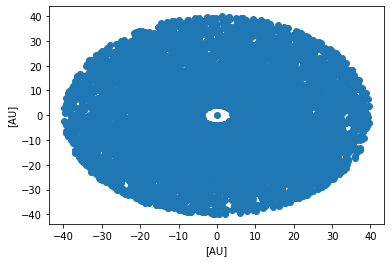

In [35]:
#plot the distribution in the orbital plane
import amuse.plot as plot
plot.scatter(complete_system.x, complete_system.y)

In [8]:
#Here we generate a galactic potential 

class MilkyWay_galaxy(object):
    def __init__(self, 
                 Mb=1.40592e10| units.MSun,
                 Md=8.5608e10| units.MSun,
                 Mh=1.07068e11 | units.MSun):
        self.Mb= Mb
        self.Md= Md
        self.Mh= Mh

    def get_potential_at_point(self,eps,x,y,z):
        r=(x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        # buldge
        b1= 0.3873 |units.kpc
        pot_bulge= -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+ (z**2+ b2**2)**0.5 )**2 )**0.5
        #halo
        a3= 12.0 |units.kpc
        cut_off=100 |units.kpc
        d1= r/a3
        c=1+ (cut_off/a3)**1.02
        pot_halo= -constants.G*(self.Mh/a3)*d1**1.02/(1+ d1**1.02) \
                  - (constants.G*self.Mh/(1.02*a3))\
                      * (-1.02/c +numpy.log(c) + 1.02/(1+d1**1.02) \
                           - numpy.log(1.0 +d1**1.02) )
        return 2*(pot_bulge+pot_disk+ pot_halo) 
                # multiply by 2 because it is a rigid potential
    
    def get_gravity_at_point(self, eps, x,y,z): 
        r= (x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        #bulge
        b1= 0.3873 |units.kpc
        force_bulge= -constants.G*self.Mb/(r**2+b1**2)**1.5 
        #disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        d= a2+ (z**2+ b2**2)**0.5
        force_disk=-constants.G*self.Md/(R**2+ d**2 )**1.5
        #halo
        a3= 12.0 |units.kpc
        d1= r/a3
        force_halo= -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))
       
        ax= force_bulge*x + force_disk*x  + force_halo*x/r
        ay= force_bulge*y + force_disk*y  + force_halo*y/r
        az= force_bulge*z + force_disk*d*z/(z**2 + b2**2)**0.5 + force_halo*z/r 

        return ax,ay,az
    
MW_potential = MilkyWay_galaxy()

In [9]:
#Here we create the conditions for the migration of the planets

def planet_migration():
    
    #velocities = 
    return velocities

final_system = complete_system#.add(velocities)
final_system.move_to_center()

In [10]:
#Here we perform the conversion for the system

final_converter=nbody_system.nbody_to_si(final_system.mass.sum(), #CHECK IF THIS IS CORRECT
                                   final_system.position.length())

In [11]:
#Here we evolve the system, also plotting the spatial evolution of the objects
from amuse.community.ph4.interface import ph4

def evolver(particle_system, potential, converter, N_objects, end_time=4*10**3, time_step=0.1):
    
    gravity_code = ph4(converter)
    gravity_code.particles.add_particles(particle_system)
    ch_g2l = gravity_code.particles.new_channel_to(particle_system)
    
    gravity_bridge = 0
    gravity_bridge = bridge.Bridge(use_threading=False)
    gravity_bridge.add_system(gravity_code, (potential,) )
    gravity_bridge.timestep = time_step|units.day

    times = np.arange(0., end_time, time_step) | units.day
    for t in tqdm(times):
        gravity_bridge.evolve_model(t)
        ch_g2l.copy()
        
        #counter_clockwise, clockwise = 0, 0
        
        plot.scatter(gravity_bridge.particles.x, gravity_bridge.particles.y, s= 2)
        
        # Plotting an AU around Jupiter to see if objects are captured
        #plot.xlim(gravity_bridge.particles[1].x -  (150*10**9 | units.m), gravity_bridge.particles[1].x + (150*10**9 | units.m))
        #plot.ylim(gravity_bridge.particles[1].y -  (150*10**9 | units.m), gravity_bridge.particles[1].y + (150*10**9 | units.m))
        names = ['Sun', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
        for i in range(5):
            plot.scatter(gravity_bridge.particles[i].x, gravity_bridge.particles[i].y, label = names[i])
        plt.legend()
            
            #proof that all orbits are counter_clockwise
        
            #if gravity_bridge.particles[i].vx < 0 | units.kms and gravity_bridge.particles[i].vy < 0 | units.kms and gravity_bridge.particles[i].x < 0 | units.AU and gravity_bridge.particles[i].y > 0 | units.AU:
            #    counter_clockwise += 1
            #elif gravity_bridge.particles[i].vx > 0 | units.kms and gravity_bridge.particles[i].vy > 0 | units.kms and gravity_bridge.particles[i].x < 0 | units.AU and gravity_bridge.particles[i].y > 0 | units.AU:
            #    clockwise += 1
        #print(counter_clockwise, clockwise)
        fig = plt.gcf()
        fig.set_size_inches(12, 9)
        clear_output(wait=True) 
        plt.show()
        
    gravity_bridge.stop()
    
    
    
evolved_system = evolver(final_system, MW_potential, final_converter, N_objects, end_time= 10000, time_step= 50)

 66%|██████▌   | 132/200 [01:55<00:59,  1.15it/s]


KeyboardInterrupt: 